In [47]:
import os
import pandas as pd
import xml.etree.ElementTree as et
from glob import glob
import numpy as np
import shutil
from shutil import copyfile
from sklearn.preprocessing import LabelEncoder

In [48]:
#create the column names and an empty list to fill in

df_columns = ['filename', 'page_height', 'page_width','type', 'x', 'y', 'width', 'height']

tmp = []

In [49]:
#find files recursively that match the filepath and *.xml extension

path = glob('tobacco_data_zhugy/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/*.xml')

In [50]:
#make a loop that iteratively adds to a list the attributes from the xml files
for file in path:
    myroot = et.parse(file).getroot()
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']
    
    filename = myroot[0].attrib['src']
    
    for item in myroot[0][0]:
        category = item.attrib['gedi_type'] #logo or signature
        x, y = item.attrib['col'], item.attrib['row'] # x and y coordinate
        width, height = item.attrib['width'], item.attrib['height'] # width and height of bounding box
            
        row = [filename, page_height, page_width, category, x, y, width, height]
        tmp.append(row)
        
    df = pd.DataFrame(tmp, columns = df_columns)

In [51]:
df

,filename,page_height,page_width,type,x,y,width,height
0,aah97e00-page02_1.tif,3296,2560,DLLogo,1074,18,374,219
1,aah97e00-page02_2.tif,3296,2560,DLSignature,1409,793,659,361
2,aam09c00.tif,2292,1728,DLSignature,821,1422,757,183
3,aao54e00_2.tif,3296,2560,DLSignature,1514,708,627,206
4,abm69c00.tif,2292,1728,DLSignature,667,1279,617,110
...,...,...,...,...,...,...,...,...
1337,zrz94a00-page02_1.tif,2156,1728,DLLogo,737,116,191,124
1338,zrz94a00-page02_2.tif,2156,1728,DLSignature,828,1046,362,91
1339,zss86d00.tif,2292,1728,DLSignature,867,1734,363,189
1340,ztz52d00-page02_2.tif,2292,1728,DLSignature,896,651,205,178


In [52]:
#delete logos since not looking for those in this case
df = df[df['type'].str.contains('DLLogo')==False]

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 1 to 1341
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     910 non-null    object
 1   page_height  910 non-null    object
 2   page_width   910 non-null    object
 3   type         910 non-null    object
 4   x            910 non-null    object
 5   y            910 non-null    object
 6   width        910 non-null    object
 7   height       910 non-null    object
dtypes: object(8)
memory usage: 64.0+ KB


# Start converting columns to a suitable format for YoloV8

In [54]:
#convert columns with numbers in to numeric
df['page_height'] = pd.to_numeric(df['page_height'])
df['page_width'] = pd.to_numeric(df['page_width'])
df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])
df['width'] = pd.to_numeric(df['width'])
df['height'] = pd.to_numeric(df['height'])

C:\Users\sinea\AppData\Local\Temp\ipykernel_23576\1721034305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['page_height'] = pd.to_numeric(df['page_height'])
C:\Users\sinea\AppData\Local\Temp\ipykernel_23576\1721034305.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['page_width'] = pd.to_numeric(df['page_width'])
C:\Users\sinea\AppData\Local\Temp\ipykernel_23576\1721034305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 1 to 1341
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     910 non-null    object
 1   page_height  910 non-null    int64 
 2   page_width   910 non-null    int64 
 3   type         910 non-null    object
 4   x            910 non-null    int64 
 5   y            910 non-null    int64 
 6   width        910 non-null    int64 
 7   height       910 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 64.0+ KB


In [56]:
#normalise the coordinates
df['x_norm'] = (df['x'] + (df['width']/2)) / df['page_width']
df['y_norm'] = (df['y'] + (df['height']/2)) / df['page_height']
df['width_norm'] = df['width'] / df['page_width']
df['height_norm'] = df['height'] / df['page_height']

C:\Users\sinea\AppData\Local\Temp\ipykernel_23576\1667169614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_norm'] = (df['x'] + (df['width']/2)) / df['page_width']
C:\Users\sinea\AppData\Local\Temp\ipykernel_23576\1667169614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_norm'] = (df['y'] + (df['height']/2)) / df['page_height']
C:\Users\sinea\AppData\Local\Temp\ipykernel_23576\1667169614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [57]:
#encode labels
le = LabelEncoder()

le.fit(df['type'])
labels = le.transform(df['type'])
df['labels'] = labels

C:\Users\sinea\AppData\Local\Temp\ipykernel_23576\2092480702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = labels


In [58]:
df

,filename,page_height,page_width,type,x,y,width,height,x_norm,y_norm,width_norm,height_norm,labels
1,aah97e00-page02_2.tif,3296,2560,DLSignature,1409,793,659,361,0.679102,0.295358,0.257422,0.109527,0
2,aam09c00.tif,2292,1728,DLSignature,821,1422,757,183,0.694155,0.660340,0.438079,0.079843,0
3,aao54e00_2.tif,3296,2560,DLSignature,1514,708,627,206,0.713867,0.246056,0.244922,0.062500,0
4,abm69c00.tif,2292,1728,DLSignature,667,1279,617,110,0.564525,0.582024,0.357060,0.047993,0
5,acr64d00.tif,2292,1728,DLSignature,886,1801,463,181,0.646701,0.825262,0.267940,0.078970,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,zrt45f00.tif,1575,1200,DLSignature,514,1019,278,48,0.544167,0.662222,0.231667,0.030476,0
1338,zrz94a00-page02_2.tif,2156,1728,DLSignature,828,1046,362,91,0.583912,0.506262,0.209491,0.042208,0
1339,zss86d00.tif,2292,1728,DLSignature,867,1734,363,189,0.606771,0.797775,0.210069,0.082461,0
1340,ztz52d00-page02_2.tif,2292,1728,DLSignature,896,651,205,178,0.577836,0.322862,0.118634,0.077661,0


In [74]:
df_train = df.iloc[:728]
df_valid = df.iloc[728:]

print(df_train.shape, df_valid.shape)

(728, 13) (182, 13)


In [75]:
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []
   
    #make the df into a format that yolo can read
    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_norm, row.y_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.filename), os.path.join(train_img_path,row.filename))

In [76]:
# Apply function
src_img_path = r"\Documents\Dissertation\tobacco_data_zhugy\Tobacco800_SinglePage\SinglePageTIF"
src_label_path = r"\Documents\Dissertation\tobacco_data_zhugy\Tobacc800_Groundtruth_v2.0\XMLGroundtruth_v2.0"

train_img_path = r"\Documents\Dissertation\yolov8\train\images"
train_label_path = r"\Documents\Dissertation\yolov8\train\labels"

valid_img_path = r"\Documents\Dissertation\yolov8\valid\images"
valid_label_path = r"\Documents\Dissertation\yolov8\valid\labels"

segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

## Analysis

In [77]:
df['filename'].mode()

0    agw39d00.tif
1    kfw39d00.tif
Name: filename, dtype: object

In [78]:
df['filename'].duplicated().sum()

134

In [81]:
(df['filename'] == 'agw39d00.tif').sum()

8

## Azure analysis

In [10]:
import cv2
import matplotlib.pyplot as plt

In [5]:
dfA = pd.read_csv('azure_predictions.csv')

In [6]:
dfA

,Unnamed: 0,ImageName,TagName,Probability,Left,Top,Width,Height
0,0,ebp68d00-page02_2.jpg,Signature,0.808588,0.503442,0.539567,0.162828,0.042704
1,1,eck05f00_1.jpg,Signature,0.873512,0.514731,0.463599,0.291193,0.059914
2,2,ecn9aa00.jpg,Signature,0.748574,0.564532,0.836222,0.246143,0.040826
3,3,ecv85f00.jpg,Signature,0.879367,0.495811,0.581591,0.247534,0.066461
4,4,ecv85f00.jpg,Signature,0.545693,0.799619,0.487201,0.116788,0.050406
...,...,...,...,...,...,...,...,...
683,683,zrt45f00.jpg,Signature,0.727482,0.437306,0.648221,0.213217,0.043649
684,684,zrz94a00-page02_2.jpg,Signature,0.800846,0.478437,0.480116,0.223795,0.061273
685,685,zss86d00.jpg,Signature,0.919356,0.493526,0.758309,0.225656,0.071592
686,686,ztz52d00-page02_2.jpg,Signature,0.825206,0.503682,0.279016,0.129172,0.073136


In [45]:
image = cv2.imread(r"\Documents\Dissertation\tobacco_data_zhugy\Tobacco800_SinglePage\Test images 1-300\ebp68d00-page02_2.jpg")

In [1]:
#convert normalised coords to pixel
width = 2544
height = 3189


x = int(0.503442 * width)
y = int(0.539567 * height)
box_width = int(0.162828 * width)
box_height = int(0.042704 * height)

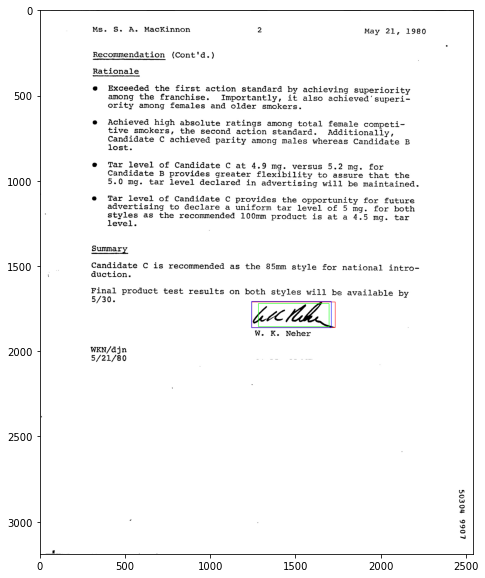

In [46]:
color = (0, 255,0)
thickness =2
image_with_box =cv2.rectangle(image, (1280, 1720), (1694, 1856), color, thickness) #azure

cv2.rectangle(image, (1241, 1711), (1730, 1861), (255, 0, 0), thickness) #yolo

cv2.rectangle(image, (1240, 1708), (1240+467, 1708+154), (0, 0, 255), thickness) #groundtruth

plt.figure(figsize=(15, 10))
plt.imshow(image_with_box)

plt.show()

In [37]:
dfA['ImageName'].nunique()

589

In [93]:
df['filename'].nunique()

776

In [68]:
docs = 776
pages = (1290 - 776)

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

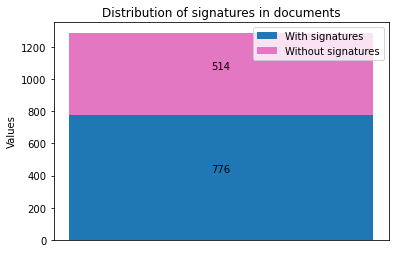

In [111]:
import matplotlib.pyplot as plt

# Data
value1 = 776
value2 = 1290 - 776

# Create figure and axes
fig, ax = plt.subplots()

# Create stacked bar plot
bars1 = ax.bar(0, value1, label='With signatures', color='tab:blue')
bars2 = ax.bar(0, value2, bottom=value1, label='Without signatures', color='tab:pink')

# Add data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Set labels and title
ax.set_ylabel('Values')
ax.set_title('Distribution of signatures in documents')
ax.set_xticks([])  # Hide x-axis tick

# Add legend
ax.legend()

plt.show()


In [6]:
import pandas as pd
df2 = pd.read_csv("xml_list.csv")
df2

,Unnamed: 0,file,page_height,page_width,author_id,overlapped,type,id,x,y,width,height
0,0,aah97e00-page02_1.tif,3296,2560,None,None,DLLogo,None,1074,18,374,219
1,1,aah97e00-page02_2.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
2,2,aam09c00.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183
3,3,aao54e00_2.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206
4,4,abm69c00.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110
...,...,...,...,...,...,...,...,...,...,...,...,...
1337,1337,zrz94a00-page02_1.tif,2156,1728,None,None,DLLogo,None,737,116,191,124
1338,1338,zrz94a00-page02_2.tif,2156,1728,"Dimech, Ellen",Yes,DLSignature,None,828,1046,362,91
1339,1339,zss86d00.tif,2292,1728,"Nielsen, Vigo G.",Yes,DLSignature,None,867,1734,363,189
1340,1340,ztz52d00-page02_2.tif,2292,1728,"Bergman, J.I.",Yes,DLSignature,None,896,651,205,178


In [7]:
import pandas as pd
df3 = pd.read_csv("azure_predictions_val.csv")
df3

,Unnamed: 0,ImageName,TagName,Probability,Left,Top,Width,Height
0,0,ufw98c00.jpg,Signature,0.816823,0.415018,0.578092,0.244225,0.068406
1,1,ufw98c00.jpg,Signature,0.635404,0.054823,0.145710,0.256243,0.083501
2,2,uiw28e00.jpg,Signature,0.851816,0.489272,0.705540,0.157868,0.093154
3,3,uji44a00.jpg,Signature,0.915137,0.588435,0.426776,0.278664,0.051132
4,4,uji44a00.jpg,Signature,0.588930,0.353644,0.433606,0.133137,0.040152
...,...,...,...,...,...,...,...,...
153,153,zrt45f00.jpg,Signature,0.727482,0.437306,0.648221,0.213217,0.043649
154,154,zrz94a00-page02_2.jpg,Signature,0.800846,0.478437,0.480116,0.223795,0.061273
155,155,zss86d00.jpg,Signature,0.919356,0.493526,0.758309,0.225656,0.071592
156,156,ztz52d00-page02_2.jpg,Signature,0.825206,0.503682,0.279016,0.129172,0.073136


In [8]:
df2.merge(df3, left_on='file', right_on='ImageName')

,Unnamed: 0_x,file,page_height,page_width,author_id,overlapped,type,id,x,y,width,height,Unnamed: 0_y,ImageName,TagName,Probability,Left,Top,Width,Height


In [9]:
df2[]

,Unnamed: 0,file,page_height,page_width,author_id,overlapped,type,id,x,y,width,height
0,0,aah97e00-page02_1.tif,3296,2560,None,None,DLLogo,None,1074,18,374,219
1,1,aah97e00-page02_2.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
2,2,aam09c00.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183
3,3,aao54e00_2.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206
4,4,abm69c00.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110
...,...,...,...,...,...,...,...,...,...,...,...,...
1337,1337,zrz94a00-page02_1.tif,2156,1728,None,None,DLLogo,None,737,116,191,124
1338,1338,zrz94a00-page02_2.tif,2156,1728,"Dimech, Ellen",Yes,DLSignature,None,828,1046,362,91
1339,1339,zss86d00.tif,2292,1728,"Nielsen, Vigo G.",Yes,DLSignature,None,867,1734,363,189
1340,1340,ztz52d00-page02_2.tif,2292,1728,"Bergman, J.I.",Yes,DLSignature,None,896,651,205,178
